# 检查版本

In [1]:
import torch
torch.version.cuda

'11.7'

In [2]:
import torch # 如果pytorch安装成功即可导入
print(torch.cuda.is_available()) # 查看CUDA是否可用
print(torch.cuda.device_count()) # 查看可用的CUDA数量
print(torch.version.cuda) # 查看CUDA的版本号
print(torch.__version__)

True
1
11.7
2.0.0+cu117


# 1.导入库

In [3]:
import os
import math
import argparse
import sys
import json
import pickle
import random

#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from functools import partial
from collections import OrderedDict
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

print(1)



1


# 2.导入数据集和数据预处理

### 2.1定义导入数据集的模型

In [4]:
class MyDataSet(Dataset):
    """自定义数据集"""

    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path   # 图片路径列表
        self.images_class = images_class  # 图片对应的类别
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        img = Image.open(self.images_path[item])  # 打开图片
        # RGB为彩色图片，L为灰度图片
        if img.mode != 'RGB':  # 判断图片是否为RGB模式
            img = img.convert('RGB')  #不是RGB则转换为RGB图像
            #raise ValueError("image: {} isn't RGB mode.".format(self.images_path[item]))
        label = self.images_class[item]  # 获取图片对应的标签

        if self.transform is not None:
            img = self.transform(img)   # 对图片进行预处理

        return img, label

    @staticmethod
    def collate_fn(batch):
        # 官方实现的default_collate可以参考
        # https://github.com/pytorch/pytorch/blob/67b7e751e6b5931a9f45274653f4f653a4e6cdf6/torch/utils/data/_utils/collate.py
        images, labels = tuple(zip(*batch))   # 按照batch进行打包

        images = torch.stack(images, dim=0)   # 将batch中的图片张量叠起来
        labels = torch.as_tensor(labels)      # 将batch中的标签转换为张量
        return images, labels
    
print(1)

1


* 数据集分割函数用于划分训练集和测试集

In [5]:
def read_split_data(root: str, val_rate: float = 0.2):
    random.seed(0)  # 保证随机结果可复现
    assert os.path.exists(root), "dataset root: {} does not exist.".format(root) #检测指定路径是否存在数据集，不存在则抛出异常并打印错误信息。

    # 遍历文件夹，一个文件夹对应一个类别，class缩写
    #保存['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
    flower_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    # 排序，保证顺序一致
    flower_class.sort()
    # 生成类别名称以及对应的数字索引，`v` 表示类别名称， `k` 表示该类别对应的数字标签。"0": "daisy","1": "dandelion",
    class_indices = dict((k, v) for v, k in enumerate(flower_class))
    json_str = json.dumps(dict((val, key) for key, val in class_indices.items()), indent=4)
    #将类别名称映射为数字标签的字典保存到 JSON 文件 class_indices.json 中。写入模式 'w' 打开文件
    with open('class_indices.json', 'w') as json_file:  
        json_file.write(json_str)

    train_images_path = []  # 存储训练集的所有图片路径
    train_images_label = []  # 存储训练集图片对应索引信息
    val_images_path = []  # 存储验证集的所有图片路径
    val_images_label = []  # 存储验证集图片对应索引信息
    every_class_num = []  # 存储每个类别的样本总数
    supported = [".jpg", ".JPG", ".png", ".PNG"]  # 支持的文件后缀类型
    # 遍历每个文件夹下的文件
    for cla in flower_class:
        cla_path = os.path.join(root, cla)
        # 遍历获取supported支持的所有文件路径
        images = [os.path.join(root, cla, i) for i in os.listdir(cla_path)
                  if os.path.splitext(i)[-1] in supported]
        # 获取该类别对应的索引
        image_class = class_indices[cla]
        # 记录该类别的样本数量
        every_class_num.append(len(images))
        # 按比例随机采样验证样本
        val_path = random.sample(images, k=int(len(images) * val_rate))

        for img_path in images:
            if img_path in val_path:  # 如果该路径在采样的验证集样本中则存入验证集
                val_images_path.append(img_path)
                val_images_label.append(image_class)
            else:  # 否则存入训练集
                train_images_path.append(img_path)
                train_images_label.append(image_class)

    print("{} images were found in the dataset.".format(sum(every_class_num))) #输出数据集中的图像数量和训练/验证集中的图像数量
    print("{} images for training.".format(len(train_images_path)))
    print("{} images for validation.".format(len(val_images_path)))

    plot_image = True   #False
    if plot_image:
        # 绘制每种类别个数柱状图
        plt.bar(range(len(flower_class)), every_class_num, align='center')
        # 将横坐标0,1,2,3,4替换为相应的类别名称
        plt.xticks(range(len(flower_class)), flower_class)
        # 在柱状图上添加数值标签
        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')
        # 设置x坐标
        plt.xlabel('image class')
        # 设置y坐标
        plt.ylabel('number of images')
        # 设置柱状图的标题
        plt.title('flower class distribution')
        plt.show()

    return train_images_path, train_images_label, val_images_path, val_images_label

print(1)

1


### 2.2 导入数据集

In [6]:
#设置数据集的参数
data_path = "./data"
batch_size = 8   #  一次读取的样本数量

21165 images were found in the dataset.
16933 images for training.
4232 images for validation.


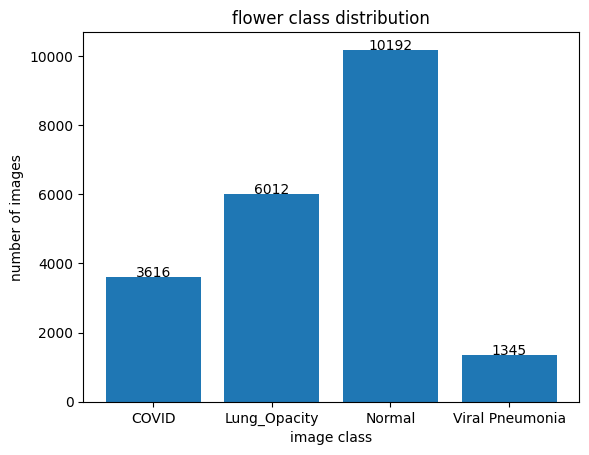

In [7]:
# 读取训练集和验证集图像路径及标签
train_images_path, train_images_label, val_images_path, val_images_label = read_split_data(data_path)

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation((-45, 45)),  # Added Random Rotation
                                 transforms.ColorJitter(brightness=0.5),  # Added Brightness Adjustment
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
}




# data_transform = {
#     "train": transforms.Compose([transforms.RandomResizedCrop(224),
#                                      transforms.RandomHorizontalFlip(),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
#     "val": transforms.Compose([transforms.Resize(256),
#                                    transforms.CenterCrop(224),
#                                    transforms.ToTensor(),
#                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])}

train_dataset = MyDataSet(images_path=train_images_path,
                              images_class=train_images_label,
                              transform=data_transform["train"])

val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                            transform=data_transform["val"])

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=0,
                                               collate_fn=train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=0,
                                             collate_fn=val_dataset.collate_fn)
print(1)

1


# 3.构建神经网络模型

### 3.1vit模型

In [9]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_c=3, embed_dim=768, norm_layer=None):
        super().__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        # flatten: [B, C, H, W] -> [B, C, HW]
        # transpose: [B, C, HW] -> [B, HW, C]
        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x


class Attention(nn.Module):
    def __init__(self,
                 dim,   # 输入token的dim
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

    def forward(self, x):
        # [batch_size, num_patches + 1, total_embed_dim]
        B, N, C = x.shape

        # qkv(): -> [batch_size, num_patches + 1, 3 * total_embed_dim]
        # reshape: -> [batch_size, num_patches + 1, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # transpose: -> [batch_size, num_heads, embed_dim_per_head, num_patches + 1]
        # @: multiply -> [batch_size, num_heads, num_patches + 1, num_patches + 1]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # @: multiply -> [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # transpose: -> [batch_size, num_patches + 1, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size, num_patches + 1, total_embed_dim]
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Mlp(nn.Module):
    """
    MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Block(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(Block, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_c=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, qkv_bias=True,
                 qk_scale=None, representation_size=None, distilled=False, drop_ratio=0.,
                 attn_drop_ratio=0., drop_path_ratio=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_c (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_ratio (float): dropout rate
            attn_drop_ratio (float): attention dropout rate
            drop_path_ratio (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
        """
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(img_size=img_size, patch_size=patch_size, in_c=in_c, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_ratio)

        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                  drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                  norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.has_logits = True
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ("fc", nn.Linear(embed_dim, representation_size)),
                ("act", nn.Tanh())
            ]))
        else:
            self.has_logits = False
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        # Weight init
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        if self.dist_token is not None:
            nn.init.trunc_normal_(self.dist_token, std=0.02)

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(_init_vit_weights)

    def forward_features(self, x):
        # [B, C, H, W] -> [B, num_patches, embed_dim]
        x = self.patch_embed(x)  # [B, 196, 768]
        # [1, 1, 768] -> [B, 1, 768]
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)  # [B, 197, 768]
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)

        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x

# ViT 模型的权重进行初始化。
#在该函数中，当输入的模块 m 是 nn.Linear 时，使用截断正态分布对其权重进行初始化（标准差为 0.01），并将偏置项初始化为 0。
#当 m 是 nn.Conv2d 时，使用 kaiming 初始化方法对其权重进行初始化，并将偏置项初始化为 0。当 m 是 nn.LayerNorm 时，将其偏置项初始化为 0，
#将其权重初始化为 1。这些初始化方法都是比较常见的权重初始化方法，例如截断正态分布可以使得网络参数的范围保持合理，
#kaiming 初始化则适用于激活函数为 ReLU 的情况，可以有效提高训练效果。
def _init_vit_weights(m):
    """
    ViT weight initialization
    :param m: module
    """
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.zeros_(m.bias)
        nn.init.ones_(m.weight)

#num_classes: int = 21843 意味着 num_classes 参数具有默认值 21843，
#这是在定义函数时为参数提供默认值的一种常见方式。如果在调用函数时不提供 num_classes 参数，则 num_classes 将被设置为默认值。
def vit_base_patch16_224_in21k(num_classes: int = 21843, has_logits: bool = True):

    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=768 if has_logits else None,
                              num_classes=num_classes)
    return model

print(1)

1


保存注意力权重，以便生成热力图

In [10]:
class AttentionWithSave(nn.Module):
    def __init__(self,
                 dim,   # 输入token的dim
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(AttentionWithSave, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

        self.saved_attention_map = None  # 新增，用于保存注意力权重

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        self.saved_attention_map = attn.detach()  # 修改，保存注意力权重
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
     
    def get_last_selfattention(self):
        return self.saved_attention_map

In [11]:
class BlockWithSave(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(BlockWithSave, self).__init__()
        self.norm1 = norm_layer(dim)
        # 修改：使用 AttentionWithSave
        self.attn = AttentionWithSave(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                                      attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

    def get_last_selfattention(self):
        return self.attn.get_last_selfattention()

In [12]:
class VisionTransformerWithSave(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_c=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, qkv_bias=True,
                 qk_scale=None, representation_size=None, distilled=False, drop_ratio=0.,
                 attn_drop_ratio=0., drop_path_ratio=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None):
        super(VisionTransformerWithSave, self).__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(img_size=img_size, patch_size=patch_size, in_c=in_c, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_ratio)

        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]
        # 修改：使用 BlockWithSave
        self.blocks = nn.Sequential(*[
            BlockWithSave(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                          drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                          norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)

        if representation_size and not distilled:
            self.has_logits = True
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ("fc", nn.Linear(embed_dim, representation_size)),
                ("act", nn.Tanh())
            ]))
        else:
            self.has_logits = False
            self.pre_logits = nn.Identity()

        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        if self.dist_token is not None:
            nn.init.trunc_normal_(self.dist_token, std=0.02)

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(_init_vit_weights)

    def forward_features(self, x):
        x = self.patch_embed(x)  
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)  
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)

        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])
            if self.training and not torch.jit.is_scripting():
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x
    
    def get_last_selfattention(self):
        for block in reversed(self.blocks):
            attn_map = block.get_last_selfattention()
            if attn_map is not None:
                return attn_map
        return None

In [13]:
def vit_base_patch16_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    model = VisionTransformerWithSave(img_size=224,
                                      patch_size=16,
                                      embed_dim=768,
                                      depth=12,
                                      num_heads=12,
                                      representation_size=768 if has_logits else None,
                                      num_classes=num_classes)
    return model
print(1)

1


In [14]:
# 模型选择
create_model = vit_base_patch16_224_in21k(num_classes=4, has_logits=False)
print(1)

1


# 4.配置模型

In [15]:
# 配置参数
#weights = "./vit_base_patch16_224_in21k.pth"
device = "cuda:0"
freeze_layers = True
lr = 0.001
lrf = 0.01
epochs = 50

In [16]:
# 选择设备：如果GPU可用则使用GPU，否则使用CPU
device = torch.device(device if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print('CUDA is available!')

CUDA is available!


In [17]:
# 创建神经网络模型，并将其移至GPU/CPU设备上（根据可用性）
model = create_model.to(device)

定义预训练权重

In [18]:
import torch

# 加载预训练权重，从本地读取，预训练权重文件和 Python 脚本位于同一个目录下
pretrained_weights = torch.load('vit_base_patch16_224_in21k.pth')

# 删除全连接层的权重
if 'head.weight' in pretrained_weights:
    del pretrained_weights['head.weight']
if 'head.bias' in pretrained_weights:
    del pretrained_weights['head.bias']

# 更新你的模型权重
create_model.load_state_dict(pretrained_weights, strict=False)


_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=['pre_logits.fc.bias', 'pre_logits.fc.weight'])

In [19]:
#     # 创建weights文件夹以保存模型权重
#     if os.path.exists("./weights") is False:
#         os.makedirs("./weights")
    
#     # 如果提供了预训练权重，则加载这些权重到模型中，但不包括head、pre_logits等层
#     if weights != "":
#         assert os.path.exists(weights), "weights file: '{}' not exist.".format(args.weights)
#         weights_dict = torch.load(weights, map_location=device)
#         # 删除不需要的权重
#         del_keys = ['head.weight', 'head.bias'] if model.has_logits \
#             else ['pre_logits.fc.weight', 'pre_logits.fc.bias', 'head.weight', 'head.bias']
#         for k in del_keys:
#             del weights_dict[k]
#         print(model.load_state_dict(weights_dict, strict=False))#用load_state_dict()方法将保存的模型权重加载到神经网络模型中。
#         #weights_dic包含预先训练好的权重。

#     #如果指定了要冻结的层，则将其权重设置为不可训练   
#     if freeze_layers:
#         for name, para in model.named_parameters():
#             # 除head, pre_logits外，其他权重全部冻结
#             if "head" not in name and "pre_logits" not in name:
#                 para.requires_grad_(False)
#             else:
#                 print("training {}".format(name))




定义优化器

In [20]:
# 获取所有需要训练的参数
pg = [p for p in model.parameters() if p.requires_grad]
# 定义优化器（使用随机梯度下降法）和学习率调度器（余弦退火）
optimizer = optim.SGD(pg, lr=lr, momentum=0.9, weight_decay=5E-5)
# 定义余弦退火函数
lf = lambda x: ((1 + math.cos(x * math.pi / epochs)) / 2) * (1 - lrf) + lrf  # cosine
# 使用LambdaLR调度器来更新学习率
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
print(1)

1


# 5.训练模型

### 5.1定义训练和验证函数

In [21]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    accu_loss = torch.zeros(1).to(device)
    accu_num = torch.zeros(1).to(device)
    optimizer.zero_grad()

    # Initialize confusion matrix
    num_classes = 4
    conf_matrix = torch.zeros(num_classes, num_classes)

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        # Update confusion matrix
        for t, p in zip(labels.view(-1), pred_classes.view(-1)):
            conf_matrix[t.long(), p.long()] += 1

        loss = loss_function(pred, labels.to(device))
        loss.backward()
        accu_loss += loss.detach()

        data_loader.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss)
            sys.exit(1)

        optimizer.step()
        optimizer.zero_grad()

    # Compute precision, recall and FPR for each class
    TP = torch.diag(conf_matrix)
    FP = conf_matrix.sum(dim=0) - TP
    FN = conf_matrix.sum(dim=1) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    fpr = FP / (FP + (conf_matrix.sum(dim=1) - FN))

    # Compute accuracy
    accuracy = TP.sum() / conf_matrix.sum()

    return accu_loss.item() / (step + 1), accuracy.item(), precision, recall, fpr


In [22]:
@torch.no_grad()
def evaluate(model, data_loader, device, epoch):
    loss_function = torch.nn.CrossEntropyLoss()

    model.eval()

    accu_num = torch.zeros(1).to(device)
    accu_loss = torch.zeros(1).to(device)

    # Initialize confusion matrix
    num_classes = 4
    conf_matrix = torch.zeros(num_classes, num_classes)

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        # Update confusion matrix
        for t, p in zip(labels.view(-1), pred_classes.view(-1)):
            conf_matrix[t.long(), p.long()] += 1

        loss = loss_function(pred, labels.to(device))
        accu_loss += loss

        data_loader.desc = "[valid epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

    # Compute precision, recall and FPR for each class
    TP = torch.diag(conf_matrix)
    FP = conf_matrix.sum(dim=0) - TP
    FN = conf_matrix.sum(dim=1) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    fpr = FP / (FP + (conf_matrix.sum(dim=1) - FN))

    # Compute accuracy
    accuracy = TP.sum() / conf_matrix.sum()

    return accu_loss.item() / (step + 1), accuracy.item(), precision, recall, fpr

print(1)

1


In [23]:
# def train_one_epoch(model, optimizer, data_loader, device, epoch):
#     model.train()    # 把模型设为训练模式
#     loss_function = torch.nn.CrossEntropyLoss()   # 定义交叉熵损失函数
#     accu_loss = torch.zeros(1).to(device)  # 累计损失，初始化累计损失，将其移动到指定设备GPU上
#     accu_num = torch.zeros(1).to(device)   # 累计预测正确的样本数
#     optimizer.zero_grad()       # 将优化器梯度清零
    
#     #记录样本数量的变量，在 for 循环开始前被初始化为 0。在该 epoch 结束时，sample_num 就会累加所有批次中的样本数量，用于计算平均准确率。
#     sample_num = 0  
#     data_loader = tqdm(data_loader, file=sys.stdout)   # 创建进度条对象
#     for step, data in enumerate(data_loader):   # 遍历数据加载器中的批次
#         images, labels = data   # 获取输入图像和标签
#         sample_num += images.shape[0]  # 记录当前批次中的样本数量

#         pred = model(images.to(device))   # 前向传播得到预测结果
#         pred_classes = torch.max(pred, dim=1)[1]  # 获取预测类别
#         accu_num += torch.eq(pred_classes, labels.to(device)).sum()   # 统计预测正确的样本数

#         loss = loss_function(pred, labels.to(device))   # 计算交叉熵损失
#         loss.backward()   # 反向传播
#         accu_loss += loss.detach()  # 累加损失值

#         # 在进度条中显示当前批次的平均损失和准确率
#         data_loader.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
#                                                                                accu_loss.item() / (step + 1),
#                                                                                accu_num.item() / sample_num)

#         if not torch.isfinite(loss):         # 如果损失值出现非法数值（比如 NaN），则中断训练
#             print('WARNING: non-finite loss, ending training ', loss)
#             sys.exit(1)

#         optimizer.step()            # 更新优化器参数
#         optimizer.zero_grad()       # 将优化器梯度清零

#     return accu_loss.item() / (step + 1), accu_num.item() / sample_num   # 返回平均损失和准确率

# print(1)

In [24]:
# @torch.no_grad()
# def evaluate(model, data_loader, device, epoch):
#     loss_function = torch.nn.CrossEntropyLoss()

#     model.eval()

#     accu_num = torch.zeros(1).to(device)   # 累计预测正确的样本数
#     accu_loss = torch.zeros(1).to(device)  # 累计损失

#     sample_num = 0
#     data_loader = tqdm(data_loader, file=sys.stdout)
#     for step, data in enumerate(data_loader):
#         images, labels = data
#         sample_num += images.shape[0]

#         pred = model(images.to(device))
#         pred_classes = torch.max(pred, dim=1)[1]
#         accu_num += torch.eq(pred_classes, labels.to(device)).sum()

#         loss = loss_function(pred, labels.to(device))
#         accu_loss += loss

#         data_loader.desc = "[valid epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
#                                                                                accu_loss.item() / (step + 1),
#                                                                                accu_num.item() / sample_num)

#     return accu_loss.item() / (step + 1), accu_num.item() / sample_num
print(1)

1


### 5.2训练

In [25]:
from datetime import datetime

# 实例化tensorboard日志记录器,在日志目录的路径中添加模型的名称和当前的日期时间
model_name = 'VIT-self'
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = './runs/{}/{}'.format(model_name, current_time)
tb_writer = SummaryWriter(log_dir=log_dir)

In [29]:
# 开始训练循环
for epoch in range(epochs):
    ## 在训练集上进行一次完整的训练迭代，并返回训练损失和准确率
    train_loss, train_acc, train_precision, train_recall, train_fpr = train_one_epoch(
        model=model,
        optimizer=optimizer,
        data_loader=train_loader,
        device=device,
        epoch=epoch
    )

    # 更新学习率
    scheduler.step()

    # 在验证集上进行测试，并返回测试损失和准确率
    val_loss, val_acc, val_precision, val_recall, val_fpr = evaluate(
        model=model,
        data_loader=val_loader,
        device=device,
        epoch=epoch
    )
        
    # 将训练/验证损失和准确率以及当前学习率写入tensorboard文件中
    tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate", 
            "train_precision", "train_recall", "train_fpr",
            "val_precision", "val_recall", "val_fpr"]
    
    tb_writer.add_scalar(tags[0], train_loss, epoch)
    tb_writer.add_scalar(tags[1], train_acc, epoch)
    tb_writer.add_scalar(tags[2], val_loss, epoch)
    tb_writer.add_scalar(tags[3], val_acc, epoch)
    tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)
    tb_writer.add_scalar(tags[5], train_precision.mean().item(), epoch)  # Save mean precision for each epoch
    tb_writer.add_scalar(tags[6], train_recall.mean().item(), epoch)     # Save mean recall for each epoch
    tb_writer.add_scalar(tags[7], train_fpr.mean().item(), epoch)        # Save mean fpr for each epoch
    tb_writer.add_scalar(tags[8], val_precision.mean().item(), epoch)    # Save mean precision for each epoch
    tb_writer.add_scalar(tags[9], val_recall.mean().item(), epoch)       # Save mean recall for each epoch
    tb_writer.add_scalar(tags[10], val_fpr.mean().item(), epoch)         # Save mean fpr for each epoch

    # 保存当前模型的权重到磁盘上
    #torch.save(model.state_dict(), "./weights/{}_epoch_{}.pth".format(model_name, epoch))

[valid epoch 49] loss: 0.161, acc: 0.949: 100%|██████████████████████████████████████| 529/529 [00:56<00:00,  9.36it/s]


# 评估模型

Confusion Matrix:
[[ 685   19   16    3]
 [   5 1098   99    0]
 [   9   48 1978    3]
 [   1    0   14  254]]


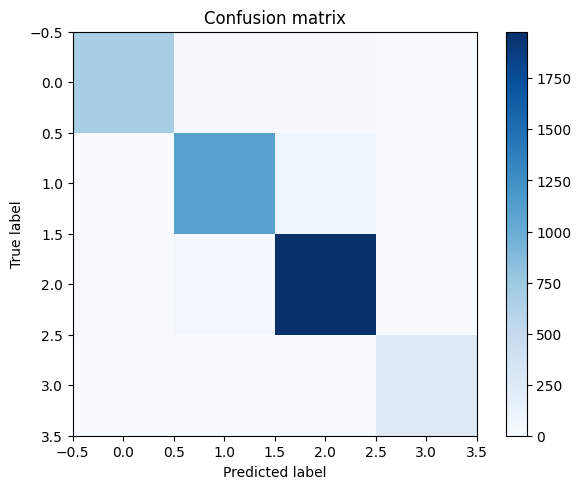

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# 首先我们需要预测所有测试集的标签，以便创建混淆矩阵
@torch.no_grad()
def get_all_preds_and_targets(model, data_loader, device):
    all_preds = torch.tensor([]).to(device)
    all_targets = torch.tensor([]).to(device)
    for data in data_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_targets = torch.cat((all_targets, labels), dim=0)
    return all_preds, all_targets

# 获取预测的类别和真实的类别
all_preds, all_targets = get_all_preds_and_targets(model, val_loader, device)
_, pred_classes = all_preds.max(dim=1)

# 创建混淆矩阵
cf_matrix = confusion_matrix(all_targets.cpu().numpy(), pred_classes.cpu().numpy())
print('Confusion Matrix:')
print(cf_matrix)

# 画出混淆矩阵
plt.imshow(cf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [31]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def plot_tensorboard_log(path):
    # 加载日志数据
    event_acc = EventAccumulator(path)
    event_acc.Reload()

    # 显示所有可以获取的数据键
    print(event_acc.Tags())

    # 获取并打印 precision、recall、FPR 和识别准确度的数据
    precision = event_acc.Scalars('train_precision')
    recall = event_acc.Scalars('train_recall')
    fpr = event_acc.Scalars('train_fpr')
    acc = event_acc.Scalars('train_acc')

    # 显示最终的 precision、recall、FPR 和 Accuracy
    print(f"Final Precision: {precision[-1].value}")
    print(f"Final Recall: {recall[-1].value}")
    print(f"Final FPR: {fpr[-1].value}")
    print(f"Final Accuracy: {acc[-1].value}")

# 假设我们的 tensorboard 日志路径是 './runs/CNN/your_time_folder'
tensorboard_log_dir = './runs/CNN/Jun06_07-57-01'
plot_tensorboard_log(tensorboard_log_dir)


{'images': [], 'audio': [], 'histograms': [], 'scalars': ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'learning_rate', 'train_precision', 'train_recall', 'train_fpr', 'val_precision', 'val_recall', 'val_fpr'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
Final Precision: 0.610902726650238
Final Recall: 0.5068568587303162
Final FPR: 0.38909727334976196
Final Accuracy: 0.6481426954269409


# 预测

torch.Size([1, 3, 224, 224])
Image shape before processing:  torch.Size([1, 3, 224, 224])


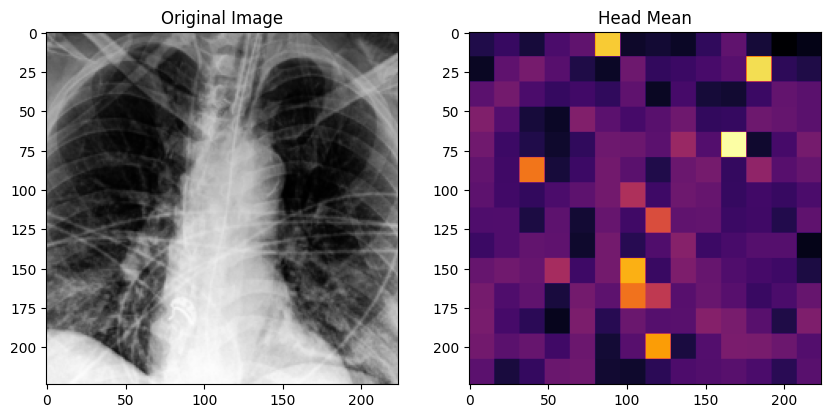

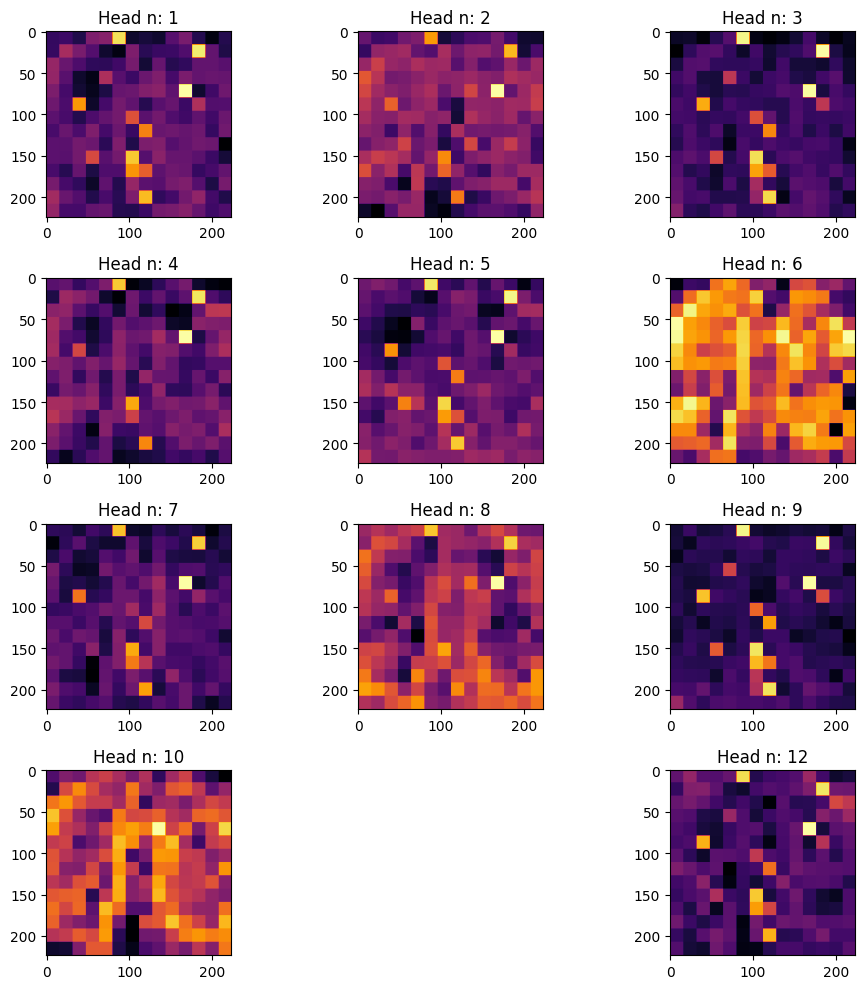

In [25]:
import os
import json
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import transforms

#VisionTransformerWithSave在前文有定义
create_model = vit_base_patch16_224_in21k(num_classes=4, has_logits=False)

def visualize_attention(model, img, patch_size, device):
    print("Image shape before processing: ", img.shape)

    # 将图像大小调整到可以被patch_size整除
    w, h = img.shape[2] - img.shape[2] % patch_size, img.shape[3] - img.shape[3] % patch_size
    img = img[:, :, :w, :h]
    w_featmap = img.shape[2] // patch_size
    h_featmap = img.shape[3] // patch_size
    # 进行模型的前向计算
    model(img.to(device))
    # 获取模型的最后一层的自注意力权重
    attentions = model.get_last_selfattention()
    nh = attentions.shape[1]  # 注意力头的数量
    # 仅保留输出patch的注意力
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    # 重新整形和插值，以在像素级别可视化注意力
    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
    return attentions

def plot_attention(img, attention):
    n_heads = attention.shape[0]
    plt.figure(figsize=(10, 10))

    # 画出原始图像和所有注意力头的平均注意力图
    text = ["Original Image", "Head Mean"]

    # 将 img 反标准化，然后进行转置
    img = img.squeeze().cpu().numpy().transpose((1, 2, 0))
    # 注意：下面这行代码的 [0.5, 0.5, 0.5] 和 [0.5, 0.5, 0.5] 需要替换为你的图像标准化使用的实际值
    img = img * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5]) 
    img = np.clip(img, 0, 1)

    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10, 10))
    # 画出每个注意力头的注意力图
    for i in range(n_heads):
        plt.subplot(n_heads//3, 3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
        plt.tight_layout()
    plt.show()

    
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    img_path = "./COVID-11.jpeg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    img = data_transform(img)
    img = torch.unsqueeze(img, dim=0)
    print(img.shape)  # Check the shape here

    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)
    with open(json_path, "r") as f:
        class_indict = json.load(f)

    model = create_model.to(device)

    weights_path = "./weights/model-9.pth"
    assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
    model.load_state_dict(torch.load(weights_path))
    model.eval()

    with torch.no_grad():
        img = img.to(device)
        model(img)
   

    attention = visualize_attention(model, img, 16, device)
    plot_attention(img, attention)  # <-- 在这里进行修改

if __name__ == "__main__":
    main()


In [27]:
import os
import json
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import transforms

#VisionTransformerWithSave在前文有定义
create_model = vit_base_patch16_224_in21k(num_classes=4, has_logits=False)

def visualize_attention(model, img, patch_size, device):
    print("Image shape before processing: ", img.shape)

    # 将图像大小调整到可以被patch_size整除
    w, h = img.shape[2] - img.shape[2] % patch_size, img.shape[3] - img.shape[3] % patch_size
    img = img[:, :, :w, :h]
    w_featmap = img.shape[2] // patch_size
    h_featmap = img.shape[3] // patch_size
    # 进行模型的前向计算
    model(img.to(device))
    # 获取模型的最后一层的自注意力权重
    attentions = model.get_last_selfattention()
    nh = attentions.shape[1]  # 注意力头的数量
    # 仅保留输出patch的注意力
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    # 重新整形和插值，以在像素级别可视化注意力
    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="bilinear", align_corners=False)[0].cpu().numpy()
    return attentions


def plot_attention(img, attention):
    n_heads = attention.shape[0]
    plt.figure(figsize=(10, 10))

    # 画出原始图像和所有注意力头的平均注意力图
    text = ["Original Image", "Head Mean"]

    # 将 img 反标准化，然后进行转置
    img = img.squeeze().cpu().numpy().transpose((1, 2, 0))
    # 注意：下面这行代码的 [0.5, 0.5, 0.5] 和 [0.5, 0.5, 0.5] 需要替换为你的图像标准化使用的实际值
    img = img * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5]) 
    img = np.clip(img, 0, 1)

    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10, 10))
    # 画出每个注意力头的注意力图
    for i in range(n_heads):
        plt.subplot(n_heads//3, 3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
        plt.tight_layout()
    plt.show()

    

# def plot_attention(img, attention):
#     n_heads = attention.shape[0]
#     plt.figure(figsize=(10, 10))
#     # 画出原始图像和所有注意力头的平均注意力图
#     text = ["Original Image", "Head Mean"]
#     for i, fig in enumerate([img, np.mean(attention, 0)]):
#         plt.subplot(1, 2, i+1)
#         plt.imshow(fig, cmap='inferno')
#         plt.title(text[i])
#     plt.show()
#     plt.figure(figsize=(10, 10))
#     # 画出每个注意力头的注意力图
#     for i in range(n_heads):
#         plt.subplot(n_heads//3, 3, i+1)
#         plt.imshow(attention[i], cmap='inferno')
#         plt.title(f"Head n: {i+1}")
#         plt.tight_layout()
#     plt.show()

def plot_attention_with_mask(img, attention):
    n_heads = attention.shape[0]
    
    # 将 img 反标准化，然后进行转置
    img = img.squeeze().cpu().numpy().transpose((1, 2, 0))
    # 注意：下面这行代码的 [0.5, 0.5, 0.5] 和 [0.5, 0.5, 0.5] 需要替换为你的图像标准化使用的实际值
    img = img * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
    img = np.clip(img, 0, 1)

    # 注意力图像，取出 Head n:1，即attention[0]
    attention_image = attention[0]

    # 创建一个全新的图像
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    #plt.title('Original Image')
    plt.title(print_res)

    # 显示原始图像叠加热力图蒙版
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(attention_image, cmap='inferno', alpha=0.5)  # alpha用来调整透明度
    #plt.title('Original Image with Attention Mask')
    plt.title(print_res)
    plt.show()




# def main():
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     img_path = "./COVID-11.jpeg"
#     assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
#     img = Image.open(img_path)
#     if img.mode != 'RGB':
#         img = img.convert('RGB')
#     data_transform = transforms.Compose(
#         [transforms.Resize(256),
#          transforms.CenterCrop(224),
#          transforms.ToTensor(),
#          transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
#     img = data_transform(img)
#     img = torch.unsqueeze(img, dim=0)
#     print(img.shape)  # Check the shape here

#     json_path = './class_indices.json'
#     assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)
#     with open(json_path, "r") as f:
#         class_indict = json.load(f)

#     model = create_model.to(device)

#     weights_path = "./weights/model-9.pth"
#     assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
#     model.load_state_dict(torch.load(weights_path))
#     model.eval()

#     with torch.no_grad():
#         img = img.to(device)
#         model(img)
   

#     attention = visualize_attention(model, img, 16, device)
#     plot_attention(img, attention)  # <-- 在这里进行修改

# if __name__ == "__main__":
#     main()

class: COVID
class: COVID        prob: 0.998
class: Lung_Opacity   prob: 0.00033
class: Normal       prob: 0.000386
class: Viral Pneumonia   prob: 0.00109
Image shape before processing:  torch.Size([1, 3, 224, 224])


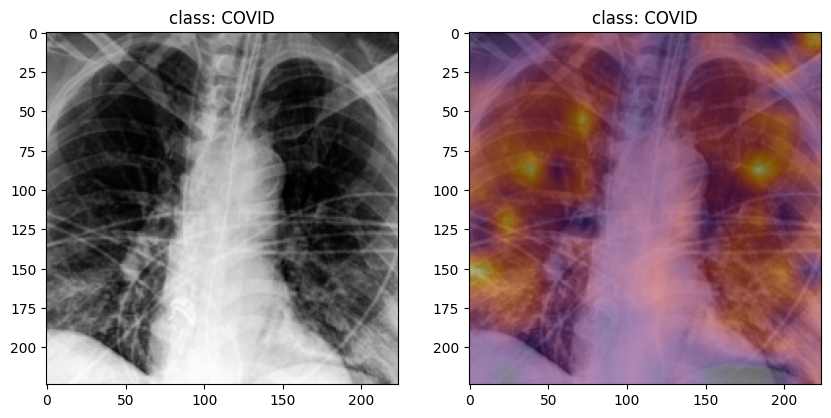

In [29]:

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    img_path = "./COVID-11.jpeg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    img = data_transform(img)
    img = torch.unsqueeze(img, dim=0)

    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)
    with open(json_path, "r") as f:
        class_indict = json.load(f)

    model = create_model.to(device)

    weights_path = "./weights/VIT-self_epoch_49.pth"
    assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
    model.load_state_dict(torch.load(weights_path))
    model.eval()

    with torch.no_grad():
        img = img.to(device)
        # predict class
        output = model(img)
        predict = torch.softmax(output, dim=-1)  # apply softmax to get probabilities
        predict_cla = torch.argmax(predict).item()

        #print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
        #                                         predict[0, predict_cla].cpu().numpy())
        print_res = "class: {}".format(class_indict[str(predict_cla)])
        print(print_res)  # print the class and probability of the predicted class

        for i in range(predict.shape[-1]):
            print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                  predict[0, i].cpu().numpy()))  # print all classes and probabilities

    attention = visualize_attention(model, img, 16, device)
    plot_attention_with_mask(img, attention)  # <-- Use this line to generate images with a mask


# obsolete code

torch.Size([1, 3, 224, 224])
class: COVID        prob: 0.377
class: Lung_Opacity   prob: 0.232
class: Normal       prob: 0.384
class: Viral Pneumonia   prob: 0.00769


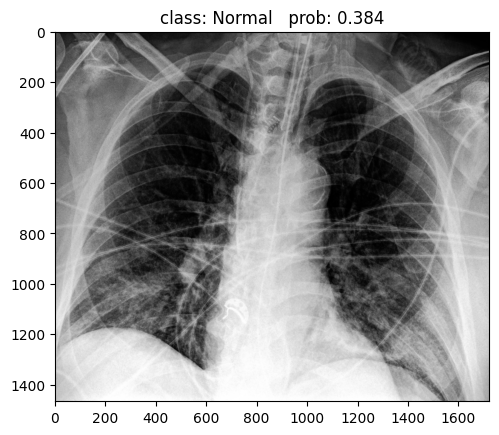

In [29]:
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # 定义一组对输入图像的转换方式
    data_transform = transforms.Compose(
        [transforms.Resize(256),  # 将图像缩放为256x256像素
         transforms.CenterCrop(224),  # 从中心裁剪出224x224像素的图像
         transforms.ToTensor(),      # 将图像转换为PyTorch张量
         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])  # 使用均值和标准差对图像像素值进行归一化

    # 加载输入图像
    img_path = "./COVID-11.jpeg" #这里是自己网上随便下的一张图片（包含在分类内），然后设置的图的路径，不是数据集里的图。
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path) # 检查指定路径下是否存在文件
    img = Image.open(img_path) # 导入PIL库打开图像
    
    # RGB为彩色图片，L为灰度图片
    if img.mode != 'RGB':  # 判断图片是否为RGB模式
        img = img.convert('RGB')
        
    plt.imshow(img)   # 使用matplotlib.pyplot显示图像
    # [N, C, H, W] 
    img = data_transform(img)   # 对输入图像应用定义好的变换
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)    #添加一个额外的维度来表示批处理大小
    print(img.shape)   #打印出图像张量的形状
    
    
    # 从json文件读取class_indict字典，类似'daisy': 0,'dandelion': 1,'roses': 2,'sunflowers': 3,'tulips': 4
    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path) # 检查指定路径下是否存在文件
    with open(json_path, "r") as f:
        class_indict = json.load(f)   # 从json文件中读取字典

    # create model
    model = create_model.to(device)
    
      # 加载模型的预训练权重
    model_weight_path = "./weights/model-9.pth" #之前训练轮次epoch是10，所以最后一次训练是epoch-9,最后的权重也是9
    model.load_state_dict(torch.load(model_weight_path, map_location=device)) # 将保存的权重加载到模型中
    model.eval()        # 设置模型为评估模式，以便在预测时不更新权重
    
    with torch.no_grad():   # 关闭梯度计算以节省内存
        # predict class 使用输入图像预测类别
        output = torch.squeeze(model(img.to(device))).cpu()   # 通过模型传递输入图像并获得输出张量
        predict = torch.softmax(output, dim=0)           # 对输出张量应用softmax激活函数以获得类别概率
        predict_cla = torch.argmax(predict).numpy()       # 获取具有最大概率的类别的索引

    # 显示预测结果
    print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    plt.title(print_res)         # 用预测的类别名称和概率设置绘图标题
    for i in range(len(predict)):
        print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                  predict[i].numpy()))      # 打印所有类别的名称和对应的概率
    plt.show()         # 显示绘图


if __name__ == '__main__':
    main()

load image from:  ./COVID-11.jpeg


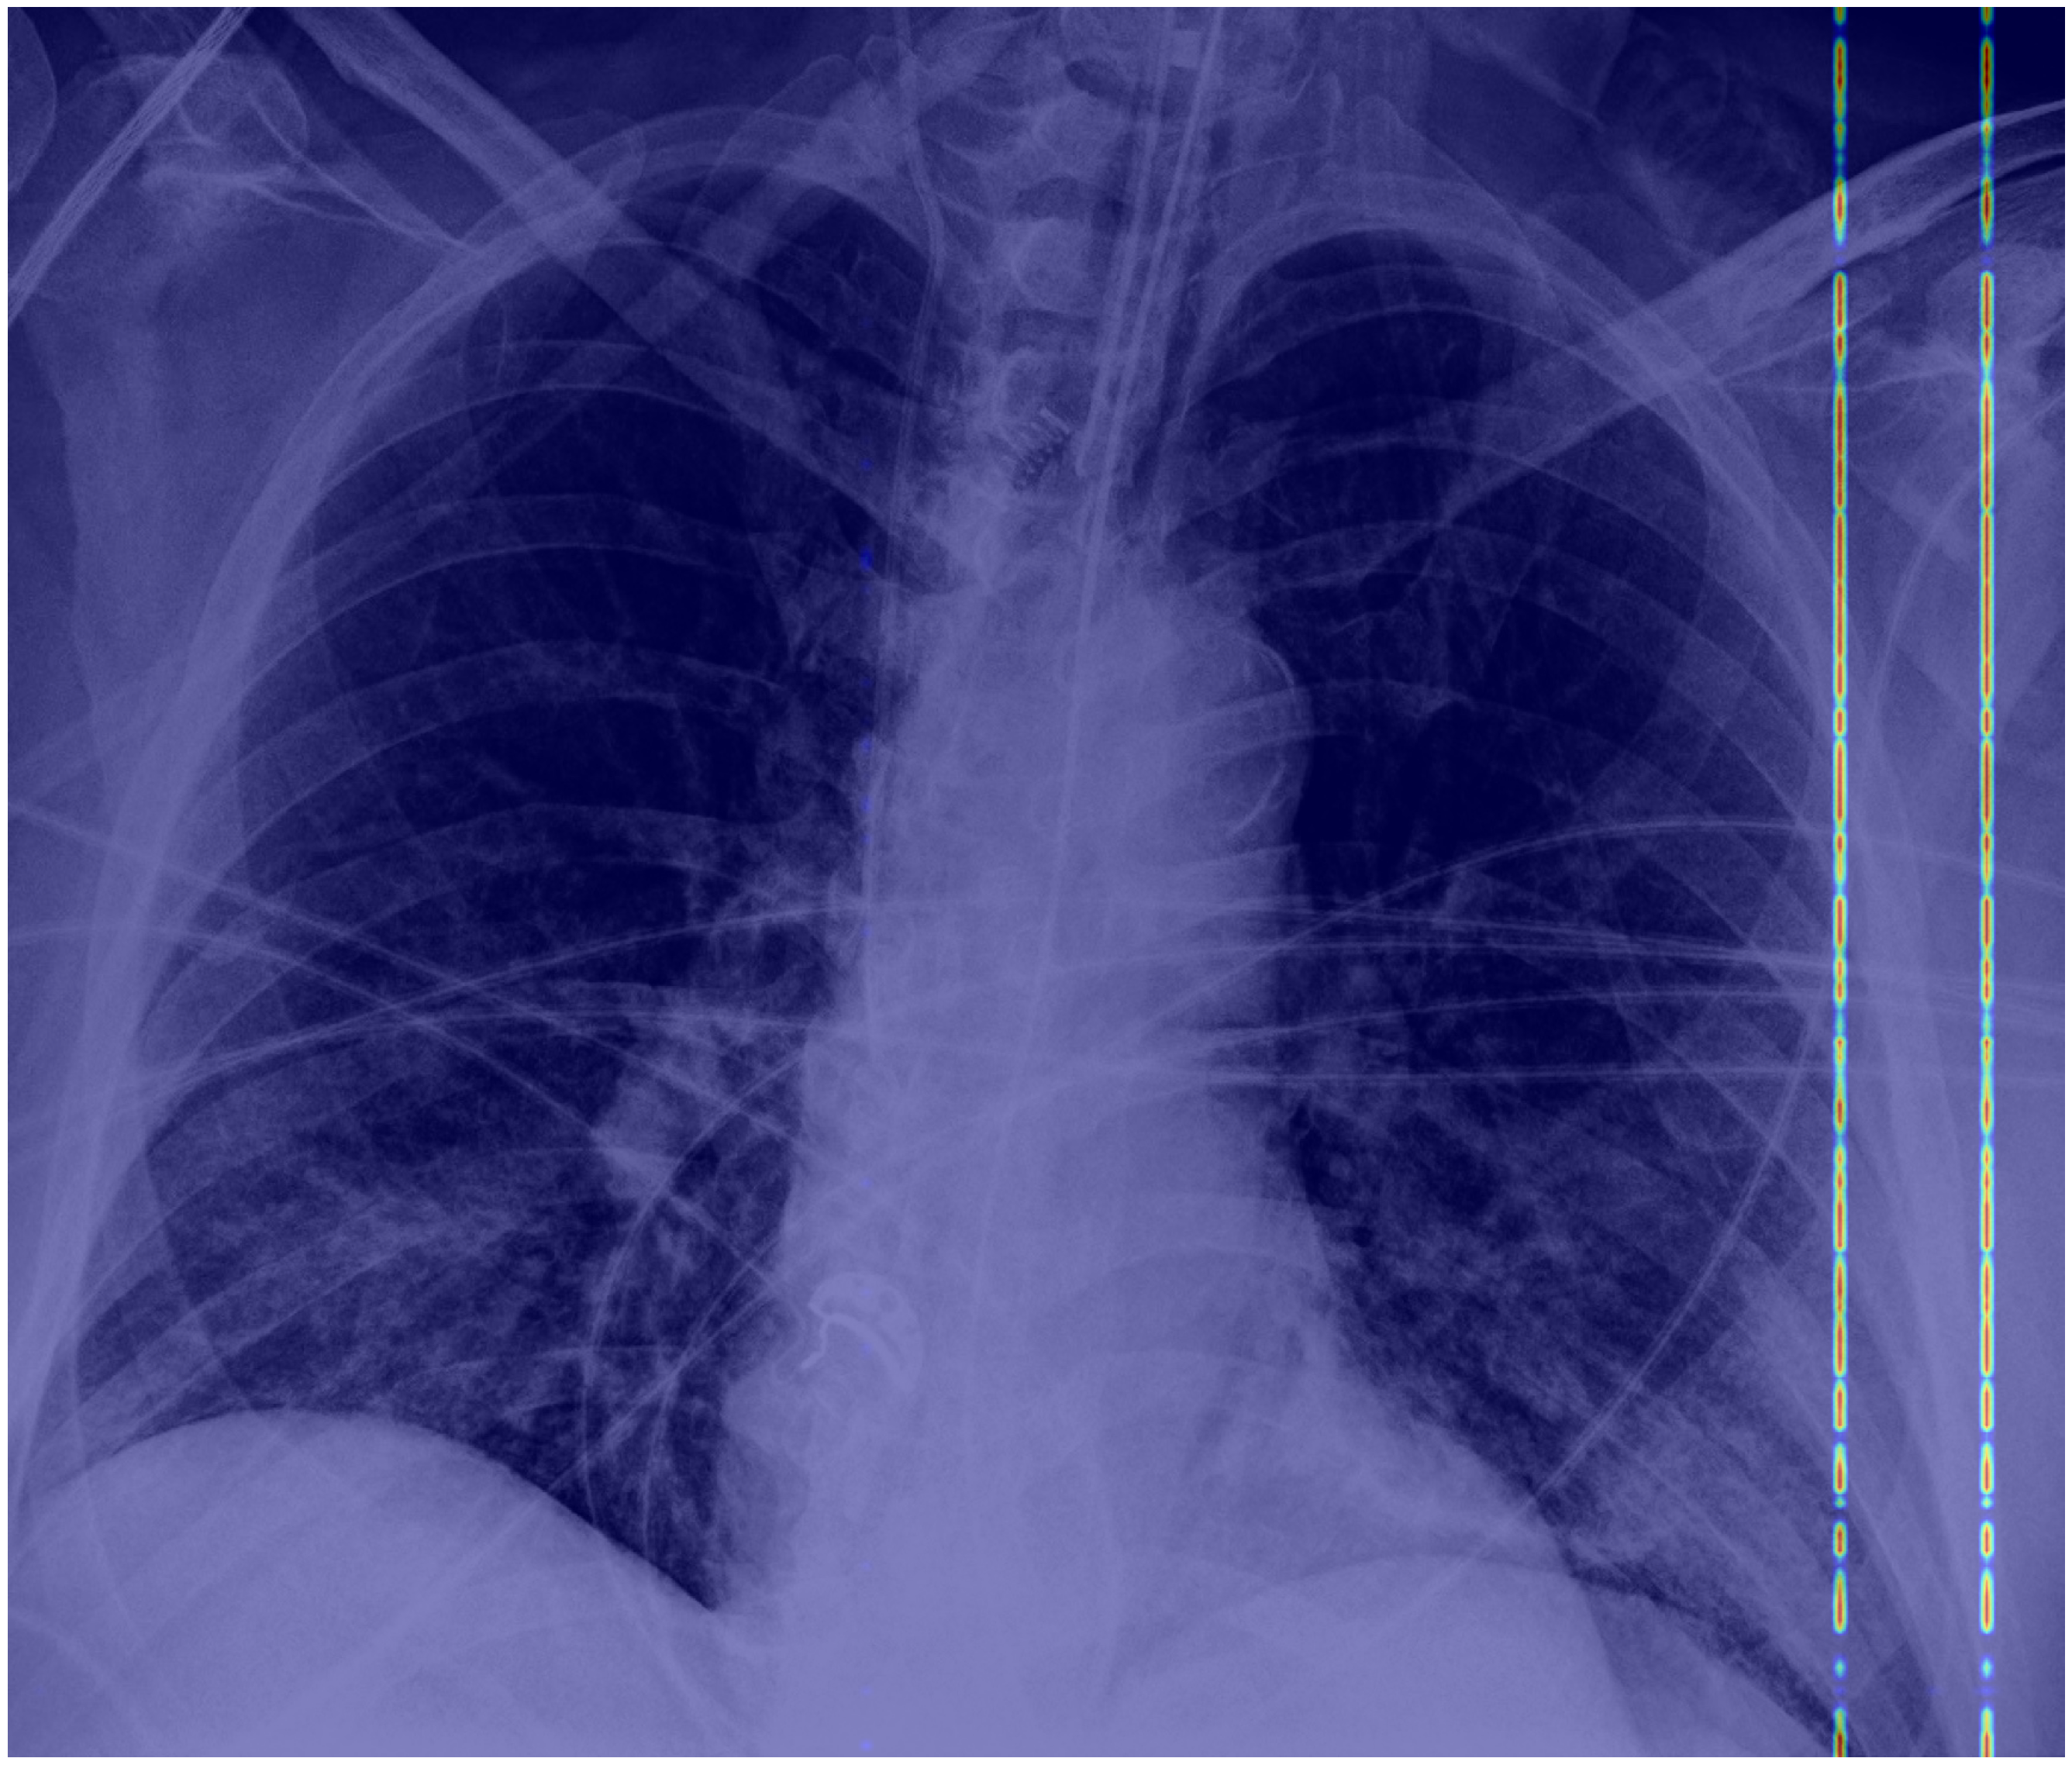

In [60]:
import os
import json
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2


#VisionTransformerWithSave在前文有定义
# 定义构建模型的函数，这里我假设你是用的是基础的ViT模型
#vit_base_patch16_224_in21k在前面有定义
create_model = vit_base_patch16_224_in21k(num_classes=4, has_logits=False)

# 定义注意力可视化的函数
def visulize_spatial_attention(img_path, attention_mask, ratio=1, cmap="jet"):
    # 加载图像
    print("load image from: ", img_path)
    img = Image.open(img_path, mode='r')
    img_h, img_w = img.size[0], img.size[1]

    # 创建画布
    plt.subplots(nrows=1, ncols=1, figsize=(0.02 * img_h, 0.02 * img_w))

    # 缩放图像
    img_h, img_w = int(img.size[0] * ratio), int(img.size[1] * ratio)
    img = img.resize((img_h, img_w))
    # 显示图像
    plt.imshow(img, alpha=1)
    # 关闭坐标轴显示
    plt.axis('off')

    # 缩放并叠加灰度化的注意力图
    mask = cv2.resize(attention_mask, (img_h, img_w))
    # 归一化注意力图
    normed_mask = mask / mask.max()
    # 将归一化后的注意力图转换为灰度图像
    normed_mask = (normed_mask * 255).astype('uint8')
    # 叠加灰度化的注意力图
    plt.imshow(normed_mask, alpha=0.5, interpolation='nearest', cmap=cmap)
    # 显示结果
    plt.show()

# 主函数
def main():
    # 判断是否有GPU设备
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 定义图片转换操作
    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # 加载图像
    img_path = "./COVID-11.jpeg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    # 对图像进行预处理
    img = data_transform(img)
    img = torch.unsqueeze(img, dim=0)

    # 加载类别信息
    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)
    with open(json_path, "r") as f:
        class_indict = json.load(f)

    # 构建模型
    model = create_model.to(device)

    # 加载预训练模型权重
    weights_path = "./weights/model-9.pth"
    assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
    model.load_state_dict(torch.load(weights_path, map_location=device))

    model.to(device)
    img = img.to(device)

    # 设置模型为评估模式
    model.eval()

    with torch.no_grad():
        output = model(img)
        # 获取预测结果
        _, predict = torch.max(output, dim=1)
        predict_class = class_indict[str(predict.item())]

    # 获取注意力图
    attn_map = model.get_last_selfattention().squeeze(0)

    # 对 num_heads 的维度求平均
    attn_map = attn_map.mean(dim=0)

    # 缩放注意力图至与原始图像一致
    attn_map = torch.nn.functional.interpolate(attn_map[None, None, :, :], size=(224, 224), mode='bilinear', align_corners=False)[0, 0]
    attn_map = attn_map.cpu().numpy()
    attn_map = np.clip(attn_map, 0, 1)



    # 可视化注意力图
    visulize_spatial_attention(img_path=img_path, attention_mask=attn_map)

# 运行主函数
if __name__ == "__main__":
    main()


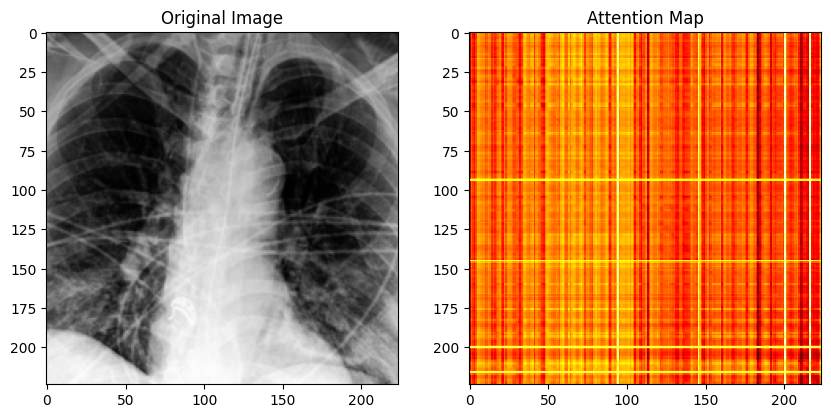

In [42]:
def denormalize(tensor):
    mean = torch.Tensor([0.5, 0.5, 0.5]).view(1, -1, 1, 1).to(tensor.device)
    std = torch.Tensor([0.5, 0.5, 0.5]).view(1, -1, 1, 1).to(tensor.device)
    return tensor * std + mean

def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    img_path = "./COVID-11.jpeg"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)

    if img.mode != 'RGB':
        img = img.convert('RGB')
        
    img = data_transform(img)
    img = torch.unsqueeze(img, dim=0)
    img = img.to(device)

    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    with open(json_path, "r") as f:
        class_indict = json.load(f)

    model = create_model.to(device)

    model_weight_path = "./weights/model-9.pth"
    model.load_state_dict(torch.load(model_weight_path, map_location=device))
    model.eval()

    with torch.no_grad():
        output = model(img)
        output = torch.squeeze(output).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    layer_index = -1  
    attn_map = model.blocks[layer_index].attn.saved_attention_map
    attn_map = attn_map.mean(dim=1)

    patch_size = 16  
    img_size = img.shape[-1]
    num_patches = (img_size // patch_size) ** 2
    attn_map = attn_map[0, :-1, :-1]
    attn_map = attn_map.reshape(num_patches, num_patches)
    attn_map = torch.nn.functional.interpolate(attn_map[None, None], size=img_size, mode='bilinear', align_corners=False)[0, 0]
    attn_map = attn_map.cpu().numpy()

    plt.figure(figsize=(10, 10))

    img_to_show = denormalize(img)[0].permute(1, 2, 0).cpu().numpy()

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img_to_show)

    plt.subplot(1, 2, 2)
    plt.title('Attention Map')
    plt.imshow(attn_map, cmap='hot', interpolation='nearest')
    plt.show()

if __name__ == '__main__':
    main()
